In [69]:
import torch
import timm
from PIL import Image
from urllib.request import urlopen
import requests
import numpy as np
import torchvision as tivision

In [70]:
import torchattacks

In [71]:
model = timm.create_model('tf_mobilenetv3_large_minimal_100.in1k', pretrained=True)
model = model.eval()

In [72]:
url = "https://raw.githubusercontent.com/anishathalye/imagenet-simple-labels/master/imagenet-simple-labels.json"
imagenet_labels = requests.get(url).json()

In [73]:
image_url = 'https://as2.ftcdn.net/v2/jpg/02/41/23/39/1000_F_241233928_3UtxKpchsTSbR4iJG9j8xSRYh3I8MyzG.jpg'
img = Image.open(urlopen(image_url))


In [94]:
#in array find ostrich index
ostrich_index = 0
for i in range(len(imagenet_labels)):
    if imagenet_labels[i] == 'ostrich':
        ostrich_index = i
        break

print(ostrich_index)

9


In [74]:
image_transforms = tivision.transforms.Compose([
        tivision.transforms.Resize((224,224)),
        tivision.transforms.ToTensor()
    ])

In [75]:
img_tensor = image_transforms(img).unsqueeze(0)

In [95]:
imagenet_labels_tensor = torch.tensor([9])

In [97]:
atk = torchattacks.DeepFool(model, steps=10, overshoot=0.02)
adv_images = atk(img_tensor, imagenet_labels_tensor)


Original image
Prediction: ostrich


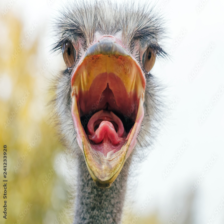

Adversarial image
Prediction: patas monkey


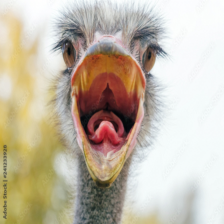

In [98]:
print("Original image")
print("Prediction:", imagenet_labels[torch.argmax(model(img_tensor)[0]).item()])
img = tivision.transforms.Resize((224,224))(img)
img.show()

print("Adversarial image")
print("Prediction:", imagenet_labels[torch.argmax(model(adv_images)[0]).item()])
tivision.transforms.ToPILImage()(adv_images[0].detach().cpu()).show()


JSMA

In [103]:
imagenet_labels_tensor = torch.tensor([123])

In [104]:
atk = torchattacks.JSMA(model, theta= 1.0, gamma=0.1)
adv_images = atk(img_tensor, imagenet_labels_tensor)

RuntimeError: [enforce fail at alloc_cpu.cpp:117] err == 0. DefaultCPUAllocator: can't allocate memory: you tried to allocate 90634715136 bytes. Error code 12 (Cannot allocate memory)

In [ ]:
print("Original image")
print("Prediction:", imagenet_labels[torch.argmax(model(img_tensor)[0]).item()])
img = tivision.transforms.Resize((224,224))(img)
img.show()

print("Adversarial image")
print("Prediction:", imagenet_labels[torch.argmax(model(adv_images)[0]).item()])
tivision.transforms.ToPILImage()(adv_images[0].detach().cpu()).show()